In [1]:
import dask.dataframe as dd
import datetime as dt
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import os

/home/chloezh/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path

In [3]:
import gensim

In [4]:
mimiciv_path = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/'

In [5]:
tbl = pd.read_csv('mimic_cxr_note_chexpert.csv')

In [6]:
tbl.head(2)

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032.0,50414267.0,CHEST (PA AND LAT),PA,3056.0,2544.0,21800506.0,213014.531,CHEST (PA AND LAT),...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032.0,53189527.0,CHEST (PA AND LAT),PA,3056.0,2544.0,21800626.0,165500.312,CHEST (PA AND LAT),...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [8]:
tbl['subject_id'].unique()

array([10000032., 10000764., 10000898., ..., 19999442., 19999733.,
       19999987.])

In [11]:
tbl.shape[0] 

243324

In [12]:
tbl['study_id'].nunique()

218131

## CXR jpg

In [4]:
## CXR
df_mimic_cxr_split = dd.read_csv(mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-split.csv', assume_missing=True)
df_mimic_cxr_chexpert = dd.read_csv(mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv', assume_missing=True)
try:
    df_mimic_cxr_metadata = dd.read_csv(mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv', assume_missing=True, dtype={'dicom_id': 'object'}, blocksize=None)
except:
    df_mimic_cxr_metadata = pd.read_csv(mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv', dtype={'dicom_id': 'object'})
    df_mimic_cxr_metadata = dd.from_pandas(df_mimic_cxr_metadata, npartitions=7)
df_mimic_cxr_negbio = dd.read_csv(mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-negbio.csv', assume_missing=True)

In [65]:
df_mimic_cxr_chexpert.head(2)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032.0,50414267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032.0,53189527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [8]:
df_mimic_cxr_metadata = df_mimic_cxr_metadata[df_mimic_cxr_metadata['ViewPosition'].isin(['PA','AP'])].compute()

In [22]:
## read corresponding notes
mimic_cxr_note_dir = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr/2.0.0/files/'

In [57]:
def add_image_note(row):
    prefix = 'p' + str(row['subject_id'])[:2]
    pat = 'p' + str(int(row['subject_id']))
    study = 's'+ str(int(row['study_id']))
    pat_path = os.path.join(mimic_cxr_note_dir,prefix,pat)
    # example: /nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267.txt
    txt_file_name = Path(os.path.join(pat_path,f'{study}.txt'))
    if txt_file_name.is_file():
        note = open(txt_file_name, "r", errors='ignore')
        img_note_text = note.read()
        note.close()
    else:
        return ''
    return img_note_text

In [82]:
df_mimic_cxr_metadata_subset = df_mimic_cxr_metadata.head(10)
df_mimic_cxr_metadata_subset.iloc[0,2] = 43526281
df_mimic_cxr_metadata_subset['note'] = df_mimic_cxr_metadata_subset.apply(add_image_note,axis=1)

/tmp/ipykernel_3388542/2733262759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mimic_cxr_metadata_subset['note'] = df_mimic_cxr_metadata_subset.apply(add_image_note,axis=1)


In [87]:
merged = dd.merge(df_mimic_cxr_metadata_subset, df_mimic_cxr_chexpert, on=['subject_id','study_id'], how='inner')

In [99]:
sum(merged['note'] == '')/len(merged)

0.0

In [61]:
df_mimic_cxr_metadata_subset['note'] = df_mimic_cxr_metadata_subset.apply(add_image_note,axis=1)

/tmp/ipykernel_3388542/1930225417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mimic_cxr_metadata_subset['note'] = df_mimic_cxr_metadata_subset.apply(add_image_note,axis=1)


In [63]:
df_mimic_cxr_metadata_subset['note'] == ''

0     True
2    False
Name: note, dtype: bool

In [34]:
for index, row in df_mimic_cxr_metadata.iterrows():
    prefix = 'p' + str(row['subject_id'])[:2]
    pat = 'p' + str(int(row['subject_id']))
    study = 's'+ str(int(row['study_id']))
    pat_path = os.path.join(mimic_cxr_note_dir,prefix,pat)
    
    # example: /nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267.txt
    txt_file_name = Path(os.path.join(pat_path,f'{study}.txt'))
    if txt_file_name.is_file():
        note = open(txt_file_name, "r", errors='ignore')
        img_note_text = note.read()
        note.close()
        break

/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267.txt
/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267.txt


In [30]:
mimic_cxr_jpg_dir = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr-jpg/2.0.0/files/'

In [ ]:
def build_mimic_cxr_jpg_dataframe(core_mimiciv_imgcxr_path, do_save=False):

    df_mimic_cxr_jpg = pd.DataFrame()
    mimic_cxr_jpg_dir = core_mimiciv_imgcxr_path
    
    #Figure out how many files we will read
    file_count = 0
    for subdir, dirs, files in os.walk(mimic_cxr_jpg_dir):
        for file in files:
            # Extract filename and extension to filter by CSV only
            filename, extension = os.path.splitext(file)
            if extension=='.txt':
                file_count = file_count + 1
                
    #Setup progress bar
    pbar = tqdm(total=file_count)
    
    #Iterate
    for subdir, dirs, files in os.walk(mimic_cxr_jpg_dir):
        for file in files:
            # Extract filename and extension to filter by CSV only
            filename, extension = os.path.splitext(file)
            if extension=='.txt':
                note = open(subdir + '/' + filename + extension, "r", errors='ignore')
                img_note_text = note.read()
                note.close()
                img_folder = subdir + '/' + filename
                
                for img_subdir, img_dirs, img_files in os.walk(img_folder):
                    for img_file in img_files:
                        # Extract filename and extension to filter by CSV only
                        img_filename, img_extension = os.path.splitext(img_file)
                        if img_extension=='.jpg':
                            df_mimic_cxr_jpg = df_mimic_cxr_jpg.append({'Note_folder': subdir.replace(core_mimiciv_imgcxr_path,''), 'Note_file': filename + extension , 'Note': img_note_text, 'Img_Folder': img_folder.replace(core_mimiciv_imgcxr_path,''), 'Img_Filename': img_filename + img_extension, 'dicom_id': img_filename}, ignore_index=True)
                            
        #Update progress bar
        pbar.update(1)
        
    #Save
    if do_save:
        try:
            df_mimic_cxr_jpg.to_csv(core_mimiciv_imgcxr_path + '/mimic-cxr-2.0.0-jpeg-txt.csv')
        except Exception as e:
            print(e)
        
    return df_mimic_cxr_jpg

## CXR note

In [ ]:
# the note is in the 
note_path = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr/2.0.0/files/'

In [5]:
note_path = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-iv-note/2.2/note'

In [6]:
data = pd.read_csv(os.path.join(note_path,'radiology.csv')).dropna()

In [7]:
data

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-RR-14,10000032,22595853.0,RR,14,2180-05-06 21:19:00,2180-05-06 23:32:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032-RR-15,10000032,22595853.0,RR,15,2180-05-06 23:00:00,2180-05-06 23:26:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032-RR-16,10000032,22595853.0,RR,16,2180-05-07 09:55:00,2180-05-07 11:15:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
6,10000032-RR-22,10000032,22841357.0,RR,22,2180-06-26 17:15:00,2180-06-26 19:28:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
7,10000032-RR-23,10000032,22841357.0,RR,23,2180-06-26 17:17:00,2180-06-26 17:28:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
...,...,...,...,...,...,...,...,...
2321350,19999987-RR-17,19999987,23865745.0,RR,17,2145-11-02 22:37:00,2145-11-03 18:55:00,"HISTORY: ___, with left occipital bleeding. ..."
2321351,19999987-RR-18,19999987,23865745.0,RR,18,2145-11-03 04:35:00,2145-11-03 10:46:00,INDICATION: ___ female intubated for head ble...
2321352,19999987-RR-19,19999987,23865745.0,RR,19,2145-11-03 16:40:00,2145-11-04 08:36:00,HISTORY: ___ woman with left occipital hemorr...
2321353,19999987-RR-20,19999987,23865745.0,RR,20,2145-11-04 05:10:00,2145-11-04 08:58:00,PORTABLE CHEST OF ___\n\nCOMPARISON: ___ radi...


In [27]:
data[['subject_id', 'hadm_id']] = data[['subject_id', 'hadm_id']].astype('int64')

In [28]:
data['charttime'] = pd.to_datetime(data['charttime'])
data['storetime'] = pd.to_datetime(data['storetime'])

In [29]:
data['text'] = data.apply(lambda x: x['text'].replace('\n', ' '), axis=1)

In [32]:
data['text'] = data.apply(lambda x: gensim.utils.simple_preprocess(x['text']), axis=1)

In [33]:
data['text']

0          [examination, chest, pa, and, lat, indication,...
1          [examination, liver, or, gallbladder, us, sing...
2          [indication, hcv, cirrhosis, ascites, hiv, on,...
6          [examination, liver, or, gallbladder, us, sing...
7          [examination, chest, pa, and, lat, indication,...
                                 ...                        
2321350    [history, with, left, occipital, bleeding, ass...
2321351    [indication, female, intubated, for, head, ble...
2321352    [history, woman, with, left, occipital, hemorr...
2321353    [portable, chest, of, comparison, radiograph, ...
2321354    [date, of, service, pre, operative, diagnosis,...
Name: text, Length: 1144758, dtype: object

In [8]:
data.shape

(1144758, 8)

In [17]:
data[data['subject_id']== 10999333]

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
228974,10999333-RR-12,10999333,27249872.0,RR,12,2129-11-17 15:54:00,2129-11-17 17:24:00,"INDICATION: ___ with elevated BNP, wheezing ..."


In [22]:
def fill_negative(x):
    if x == -1:
        return 1
    else:
        return x

In [19]:
columns_to_update = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
    'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]
tbl[columns_to_update] = tbl[columns_to_update].apply(lambda x: 1 if x == -1 else x)

SyntaxError: invalid syntax (3901394992.py, line 7)

In [46]:
tbl.loc[:, columns_to_update] = tbl.loc[:, columns_to_update].replace(-1, 0)

In [17]:
tbl[['Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
       'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding',
       'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax',
       'Support Devices']] = tbl[['Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
       'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding',
       'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax',
       'Support Devices']].fillna(0)

## test dataset

In [7]:
from pathlib import Path
import torchxrayvision.datasets as xrv_data
import numpy as np
import pandas as pd
from skimage.io import imread
import torch, random
from torch.utils.data import Dataset

In [8]:
import os

In [23]:


def apply_transforms(sample, transform, seed=None, transform_seg=False):
    if seed is None:
        MAX_RAND_VAL = 2147483647
        seed = np.random.randint(MAX_RAND_VAL)

    if transform is not None:
        random.seed(seed)
        torch.random.manual_seed(seed)
        sample["img"] = transform(sample["img"])

    return sample

class MIMIC_CXRDataset(xrv_data.Dataset):
    """
    Input:
        csvpath <python str>: path to the csv file
        views <python list>: list of views to use
        seed <python int>: seed for randomization
        unique_patients <python bool>: if True, only use one image per patient
        transforms <torchvision.transforms>: transforms to apply to the image
        xrv_normalize <python bool>: if True, normalize the image using the xrv normalize function
    """

    def __init__(self,
                 csvpath,
                 views=["PA", "AP"],
                 seed=42,
                 transforms=None,
                 xrv_normalize=0
                 ):

        super(MIMIC_CXRDataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.

        self.img_root = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr-jpg/2.0.0/files/'
        self.transforms = transforms
        self.xrv_normalize = xrv_normalize
        self.label_columns = ['Atelectasis',
                   'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
                   'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding',
                   'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax',
                   'Support Devices']

        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath)
        
        self.labels = self.csv[self.label_columns]
        self.labels = self.labels.fillna(0)
        self.labels = self.labels.replace(-1, 0)
        
        

    @property
    def csv_file(self):
        return self.csv
    
    def __len__(self):
        return self.csv.shape[0]
    
    def get_img_path(self,idx):
        row = self.csv.iloc[idx,:]
        prefix = 'p' + str(row['subject_id'])[:2]
        pat = 'p' + str(int(row['subject_id']))
        study = 's'+ str(int(row['study_id']))
        dicom_id = str((row['dicom_id'])) 
        pat_path = os.path.join(self.img_root,prefix,pat,study)
        self.jpg_name = Path(os.path.join(pat_path,f'{dicom_id}.jpg'))
        label = self.labels.iloc[idx,:]
        
        return self.jpg_name,label

    def __getitem__(self, idx):

        sample = {}
        sample["idx"] = idx
        
        img_path,label = self.get_img_path(idx)
        sample['label'] = list(label)
        sample['img_path'] = img_path.__str__()
        if self.xrv_normalize == 1:
            # single channel output renormliazed to [-1024, 1024]
            sample["img"] = xrv_data.normalize(imread(str(img_path)), maxval=255, reshape=True)
        elif self.xrv_normalize == 0:
            # single channel output renormliazed to [0, 1]
            sample["img"] = imread(str(img_path), as_gray=True).astype(np.float32) / 255.
        elif self.xrv_normalize == 2:
            # single channel output renormliazed to [0, 255]
            img = imread(str(img_path), as_gray=True)
            img = ((img - img.min()) / (img.max() - img.min())) * 255.
            img = img.astype('uint8')
            sample["img"] = img

        if self.transforms is not None:
            sample = apply_transforms(sample, self.transforms)

        return sample

In [10]:
# !pip install -qU torchxrayvision

243324


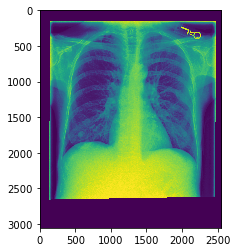

In [11]:
dataset = MIMIC_CXRDataset(csvpath = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Code/Yufeng/multimodal/mimic_cxr_note_chexpert.csv')
sample = dataset[0]
print(len(dataset))
img = sample['img']
import matplotlib.pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [22]:
list(sample['label'])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [24]:
from pathlib import Path
import numpy as np
import torch.utils.data as module_data
import torch.utils.data.dataloader as module_default_dataloader
import torch.utils.data.sampler as module_sampler
from torchvision import transforms
import torchxrayvision.datasets as module_xrv_data
import torch

def apply_transforms(sample, transform, seed=None, transform_seg=False):
    if seed is None:
        MAX_RAND_VAL = 2147483647
        seed = np.random.randint(MAX_RAND_VAL)

    if transform is not None:
        random.seed(seed)
        torch.random.manual_seed(seed)
        sample["img"] = transform(sample["img"])

    return sample


class SplitDataLoader(module_data.DataLoader):

    def __init__(self, dataset, batch_size, shuffle=True,
                 split_method="patient-wise", split_ratio=0.3,num_workers=0,seed = 42, 
                 collate_fn=module_default_dataloader.default_collate):
        
        self.dataset = dataset
        self.table = self.dataset.csv
        self.shuffle = shuffle
        self.split_method = split_method
        self.split_ratio = split_ratio
        self.seed = seed
        self.n_samples = len(dataset)
        self._split_sampler()

        self.init_kwargs = {
            'dataset': self.dataset,
            'batch_size': batch_size,
            'shuffle': self.shuffle,
            'collate_fn': collate_fn,
            'num_workers': num_workers
        }
        
        super().__init__(**self.init_kwargs)

    def _split_sampler(self):

        if self.split_method == 'patient-wise':
            patients = self.table['subject_id'].unique()
        else:
            patients = np.arange(self.table['subject_id'].shape[0])
            
        patient_col = 'subject_id'

        np.random.seed(self.seed)
        np.random.shuffle(patients)

 
        len_valid = int(len(patients) * self.split_ratio)

        valid_patients = patients[0:len_valid]
        train_patients = np.delete(patients, np.arange(0, len_valid))

        self.train_idx = list(self.table[self.table[patient_col].isin(train_patients)].index)
        self.valid_idx = list(self.table[self.table[patient_col].isin(valid_patients)].index)

        self.train_sampler = module_sampler.SubsetRandomSampler(self.train_idx)
        self.valid_sampler = module_sampler.SubsetRandomSampler(self.valid_idx)
        self.n_samples = len(train_patients)
        
        self.shuffle = False


    def get_data_loader(self):
        train_loader = module_data.DataLoader(sampler=self.train_sampler, **self.init_kwargs)
        val_loader = module_data.DataLoader(sampler=self.valid_sampler, **self.init_kwargs)
        return train_loader,val_loader
        


class CheXpertDataLoader(SplitDataLoader):

    def __init__(self, data_dir, batch_size, image_size,  
                 split_method="patient-wise", split_ratio=0.3, num_workers=0, xrv_normalize=False):

        if xrv_normalize:
            # input channel = 1
            trsfm = transforms.Compose([
                module_xrv_data.XRayCenterCrop(), # just to make it square
                module_xrv_data.XRayResizer(image_size)
            ])
        else:
            # input channel = 3
            trsfm = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(), 
                transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Turn grayscale to RGB
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
        self.dataset = MIMIC_CXRDataset(data_dir,transforms=trsfm, xrv_normalize=xrv_normalize)

        super().__init__(self.dataset, batch_size,
                         num_workers=num_workers, split_method=split_method,split_ratio = split_ratio)
        
    
    def get_dataset(self):
        return self.dataset

In [25]:
loader = CheXpertDataLoader(data_dir = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Code/Yufeng/multimodal/mimic_cxr_note_chexpert.csv'
                           ,batch_size = 4, image_size = 224,
                           )

In [26]:
train_loader,val_loader = loader.get_data_loader() 


In [27]:
num_batches = len(train_loader)
print("Number of batches in train_loader:", num_batches)
batch_size = train_loader.batch_size
print("Batch size of train_loader:", batch_size)

num_batches = len(val_loader)
print("Number of batches in val_loader:", num_batches)
batch_size = val_loader.batch_size
print("Batch size of val_loader:", batch_size)

Number of batches in train_loader: 42445
Batch size of train_loader: 4
Number of batches in val_loader: 18387
Batch size of val_loader: 4


In [31]:
for sample in train_loader:
    print(sample)
    break

{'idx': tensor([ 89547, 221018,  27375,   2788]), 'label': [tensor([0., 0., 0., 1.], dtype=torch.float64), tensor([0., 0., 1., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 1., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 1.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0., 0.], dtype=torch.float64)], 'img_path': ['/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13688556/s57146592/8583425a-07cad26a-209244cb-6677ccf5-ac6e0f96.jpg', '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr-j

In [ ]:
class MIMIC_NoteDataset(xrv_data.Dataset):
    """
    Input:
        csvpath <python str>: path to the csv file
        views <python list>: list of views to use
        seed <python int>: seed for randomization
        unique_patients <python bool>: if True, only use one image per patient
        transforms <torchvision.transforms>: transforms to apply to the image
        xrv_normalize <python bool>: if True, normalize the image using the xrv normalize function
    """

    def __init__(self,
                 csvpath,
                 views=["PA", "AP"],
                 seed=42,
                 transforms=None,
                 xrv_normalize=0
                 ):

        super(MIMIC_CXRDataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.

        self.img_root = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/mimic-cxr-jpg/2.0.0/files/'
        self.transforms = transforms
        self.xrv_normalize = xrv_normalize
        self.label_columns = ['Atelectasis',
                   'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
                   'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding',
                   'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax',
                   'Support Devices']

        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath)
        
        self.labels = self.csv[self.label_columns]
        self.labels = self.labels.fillna(0)
        self.labels = self.labels.replace(-1, 0)
        
        

    @property
    def csv_file(self):
        return self.csv
    
    def __len__(self):
        return self.csv.shape[0]
    
    def get_img_path(self,idx):
        row = self.csv.iloc[idx,:]
        prefix = 'p' + str(row['subject_id'])[:2]
        pat = 'p' + str(int(row['subject_id']))
        study = 's'+ str(int(row['study_id']))
        dicom_id = str((row['dicom_id'])) 
        pat_path = os.path.join(self.img_root,prefix,pat,study)
        self.jpg_name = Path(os.path.join(pat_path,f'{dicom_id}.jpg'))
        label = self.labels.iloc[idx,:]
        
        return self.jpg_name,label

    def __getitem__(self, idx):

        sample = {}
        sample["idx"] = idx
        
        img_path,label = self.get_img_path(idx)
        sample['label'] = label
        sample['img_path'] = img_path
        if self.xrv_normalize == 1:
            # single channel output renormliazed to [-1024, 1024]
            sample["img"] = xrv_data.normalize(imread(str(img_path)), maxval=255, reshape=True)
        elif self.xrv_normalize == 0:
            # single channel output renormliazed to [0, 1]
            sample["img"] = imread(str(img_path), as_gray=True).astype(np.float32) / 255.
        elif self.xrv_normalize == 2:
            # single channel output renormliazed to [0, 255]
            img = imread(str(img_path), as_gray=True)
            img = ((img - img.min()) / (img.max() - img.min())) * 255.
            img = img.astype('uint8')
            sample["img"] = img

        if self.transforms is not None:
            sample = apply_transforms(sample, self.transforms)

        return sample